# Анализ продуктовых метрик чат-бота

В базе данных чат-бота собирается информация о сообщениях, отправленных пользователями, а также о заказах, которые они через чат-бота оформили. Эти заказы попадают к администратору, для каждого заказа цена определяется индивидуально и озвучивается клиенту, после чего клиент может сделать заказ или отказаться. 
Информация о решении клиента и стоимости заказа не попадает в базу данных, поэтому не анализируется в данном отчёте (+NDA по части финансовых результатов). 

Имеются данные о заявках, сделанных клиентами, их дальнейший статус неизвестен (если не подключать другие источники данных), поэтому в этом отчёте рассматриваются продуктовые метрики, которые могут быть рассчитаны без этой информации, а именно: 
* показатели MAU, WAU, DAU по оформленным заявкам;
* показатели удержания клиентов (Retention Rate) - в контексте повторных заявок, имеющих статус завершённых;
* показатели конверсии в повторную заявку и коэффициент повторных заявок;
* коэффициент LT клиента (Customer LifeTime) - время жизни клиента, т.е. срок, в течение которого он остаётся потенциальным покупателем услуги. 

Перечисленные выше метрики рассчитываются суммарно, а также в разрезе отдельных проектов и периодов. 

In [72]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta as td
import plotly.express as px
import plotly.graph_objects as go

In [73]:
# получение данных с Яндекс-диска

import requests
import urllib
import json

import warnings
warnings.filterwarnings('ignore')

folder_url = 'https://disk.yandex.ru/d/kCr2Plesa4vsOA'
filename = 'orders.csv'

def create_df_from_url(source_url, file_url, sep = ','):
    yandex_download_api_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download'
    full_url = yandex_download_api_url + \
               '?public_key=' + urllib.parse.quote(source_url) + '&path=/' + urllib.parse.quote(file_url)
    r = requests.get(full_url) # запрос ссылки на скачивание
    h = json.loads(r.text)['href'] # 'парсинг' ссылки на скачивание
    df = pd.read_csv(h, sep, error_bad_lines=False, comment='#')
    return df

orders = create_df_from_url(folder_url, filename).drop(columns = 'Unnamed: 0')
orders['created_at'] = pd.to_datetime(orders['created_at'])
orders['finished_at'] = pd.to_datetime(orders['finished_at'])
orders['month'] = orders['created_at'].dt.month
orders['group'] = np.where(orders['group_id'] == 101414135, "ECM",
                           (np.where(orders['group_id'] == 60444948, "Fin", 
                                     (np.where(orders['group_id'] == 50757966, "Stat", "Other")))))
orders = orders[(orders['group'] != 'Other') & (orders['month'] != 7)]
orders = orders.drop(columns = 'group_id')
print('Таблица заказов:')
display(orders.head())

Таблица заказов:


,id,created_at,status,order_type,user_id,finished_at,month,group
0,334,2021-11-13 11:12:20.877591+00:00,finished,offline,349,2021-11-13 11:42:11.869742+00:00,11,ECM
1,216,2021-10-13 18:02:30.437135+00:00,cancelled,online,140,2021-10-13 18:02:30.437135+00:00,10,Fin
2,664,2021-12-24 16:36:22.964909+00:00,cancelled,online,694,2021-12-24 16:36:22.964909+00:00,12,Fin
3,703,2022-01-01 08:34:19.799899+00:00,finished,online,117,2022-01-02 05:23:13.787937+00:00,1,ECM
4,665,2021-12-24 18:04:17.719299+00:00,cancelled,online,239,2021-12-24 18:04:17.719299+00:00,12,Fin


# Оценка DAU, WAU, MAU по периодам

Исходная таблица содержит данные о заявках не во все возможные дни анализируемого периода. В некоторые дни заявок не было ни по одному проекту, поэтому необходимо сначала дополнить их этими днями, указав число заявок на соответствующую дату равной нулю. После чего переходить к расчёту метрик. 

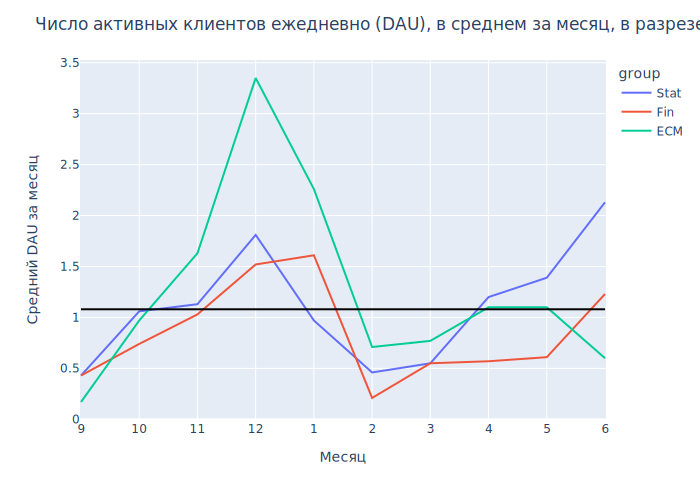

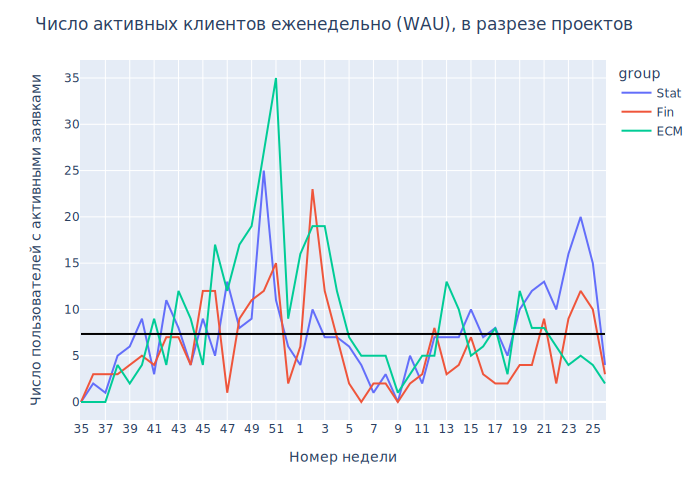

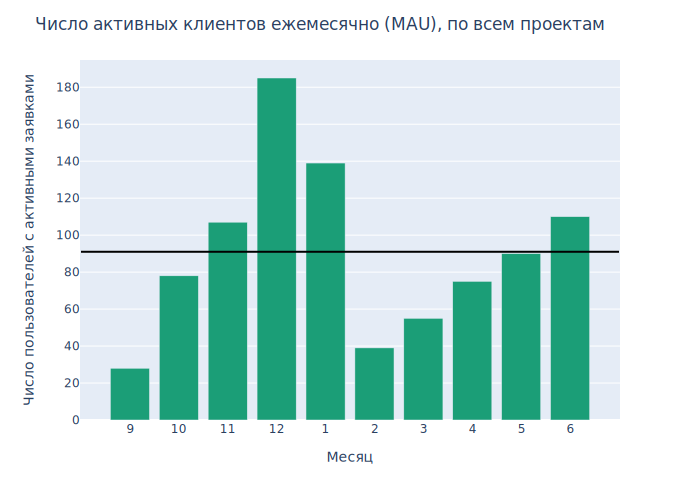

Средний DAU в целом за период, в среднем на один проект: 1.08
Средний WAU в целом за период, в среднем на один проект: 7.35
Средний MAU в целом за период по всем проектам: 91.0


In [74]:
# расчёт числа ежедневных активных пользователей (DAU) (в среднем по месяцам)

orders['date'] = orders['finished_at'].dt.date
orders_grouping = orders[orders['status'] == 'finished'] \
                        .groupby(['date', 'user_id', 'group'], as_index = False) \
                        .agg({'id':'count'}).rename(columns = {'id':'orders_count'})
orders_grouping['date'] = pd.to_datetime(orders_grouping['date'])

sdate = dt.date(2021, 9, 1)
edate = dt.date(2022, 6, 30)
all_days = pd.DataFrame(pd.date_range(sdate,edate,freq='d'))
groups = pd.Series(orders.group.unique(), name='group')
full_orders_grouping = all_days.merge(groups, how = 'cross').rename(columns={0:'date'})
full_orders_grouping = full_orders_grouping.merge(orders_grouping, how = 'left', on = ['group', 'date'])
full_orders_grouping['orders_count'] = full_orders_grouping['orders_count'].fillna(0)
full_orders_grouping['month'] = pd.to_datetime(full_orders_grouping['date']).dt.month
full_orders_grouping['week'] = pd.to_datetime(full_orders_grouping['date']).dt.week

avg_DAU = full_orders_grouping.groupby(['date', 'group'], as_index = False).agg({'user_id':'nunique'}).mean()
avg_DAU = avg_DAU.round(2)[0]

DAU_by_month = full_orders_grouping.groupby(['date', 'month', 'group'], as_index = False) \
                                   .agg({'user_id':'nunique'}) \
                                   .groupby(['month', 'group'], as_index = False) \
                                   .agg({'user_id':'mean'}).round(2)

month_order = [9, 10, 11, 12, 1, 2, 3, 4, 5, 6]
DAU_by_month['month'] = pd.Categorical(DAU_by_month['month'], month_order)
DAU_by_month = DAU_by_month.sort_values("month")


fig = px.line(DAU_by_month, y = 'user_id', x = 'month', color = 'group')
fig.update_xaxes(title_text='Месяц', type = 'category')
fig.update_yaxes(title_text = 'Средний DAU за месяц')
fig.update_layout(title_text = 'Число активных клиентов ежедневно (DAU), в среднем за месяц, в разрезе проектов')
fig.add_shape(type='line',
                x0=0,
                y0=avg_DAU,
                x1=max(month_order)-3,
                y1=avg_DAU,
                line=dict(color='Black'),
                xref='x',
                yref='y'
)

fig.show('svg')

# расчёт еженедельных активных пользователей (WAU) - за каждую неделю за весь период анализа

count_by_weeks = full_orders_grouping.groupby(['week', 'group'], as_index=False) \
                                     .agg({'user_id':'nunique'}) \
                                     .rename(columns = {'user_id':'count_users'})

weeks_order = [i for i in range(35,53)]
weeks_order.extend([i for i in range(1,27)])
count_by_weeks['week'] = pd.Categorical(count_by_weeks['week'], weeks_order)
count_by_weeks = count_by_weeks.sort_values("week")

avg_WAU = count_by_weeks['count_users'].mean().round(2)

fig2 = px.line(count_by_weeks, y = 'count_users', x = 'week', color = 'group')
fig2.update_xaxes(title_text='Номер недели', type = 'category')
fig2.update_yaxes(title_text = 'Число пользователей с активными заявками')
fig2.update_layout(title_text = 'Число активных клиентов еженедельно (WAU), в разрезе проектов')
fig2.add_shape(type='line',
                x0=0,
                y0=avg_WAU,
                x1=max(weeks_order)-9,
                y1=avg_WAU,
                line=dict(color='Black'),
                xref='x',
                yref='y'
)

fig2.show('svg')

# расчёт ежемесячных активных пользователей

total_MAU = full_orders_grouping.groupby('month', as_index = False) \
                                .agg({'user_id':'nunique'}) \
                                .rename(columns = {'user_id':'count_users'})
avg_MAU = total_MAU['count_users'].mean().round(0)

fig3 = px.bar(
    data_frame=total_MAU,
    x="month",
    y="count_users",
    color_discrete_sequence=px.colors.qualitative.Dark2)

fig3.update_xaxes(type='category', title_text='Месяц', 
                 categoryorder='array', categoryarray= [9, 10, 11, 12, 1, 2, 3, 4, 5, 6])
fig3.update_yaxes(title_text='Число пользователей с активными заявками')
fig3.update_layout(title_text = 'Число активных клиентов ежемесячно (MAU), по всем проектам')
fig3.add_shape(type='line',
                x0=-1,
                y0=avg_MAU,
                x1=max(month_order)-2,
                y1=avg_MAU,
                line=dict(color='Black'),
                xref='x',
                yref='y'
)
fig3.show('svg')

print(f'Средний DAU в целом за период, в среднем на один проект: {avg_DAU}')
print(f'Средний WAU в целом за период, в среднем на один проект: {avg_WAU}')
print(f'Средний MAU в целом за период по всем проектам: {avg_MAU}')

**Вывод.**

Средняя ежедневная активность пользователей увеличивается в ноябре-январе и в мае-июне - в эти периоды число ежедневных активных пользователей выше средней за весь период. В остальные месяцы активность сильно проседает. Причём **в проектах Fin, ECM активность зимой выше, чем летом**. А **в проекте Stat наблюдается обратная картина**. 

По недельному графику активных пользователей можно выделить **периоды резкой просадки активности** - до Нового года и в течение новогодних каникул (52-я и 1-я недели), в конце июня (25-26 недели), а также в начале мая (18-я неделя). Всплеск активности, помимо "сезонных" мая-июня и декабря-января также наблюдаются в апреле.

Недельный график показывает, что рост активности в сезонный период происходит нелинейно. Фактически, **максимумы активности наблюдаются в течение одной-двух недель сезонного периода**. В остальные недели "сезонных" периодов график колеблется вокруг среднегодового уровня. 
Кроме того, график **не подтверждает роста активности в проекте Stat летом** - пиковые значения недельной активности в этом проекте всё равно приходятся на зимний период. 

График ежемесячной активности показывает, что уровень активности в летний период хотя и увеличивается, но он в 1,5 раза ниже, чем в зимний. Спрос зимой в целом выше, но этот эффект также может объясняться "новогодней лихорадкой", которая проявляется в том, что клиенты стремятся под конец года сделать как можно больше дел и решить как можно больше вопросов. Поэтому в декабре активность выше и линейная динамика нарушается. 

Но могут быть и другие причины, поэтому необходимо рассматривать динамику активности за несколько лет, чтобы получить более адекватное представление о соотношении активности в зимний и летний периоды. 

# Оценка наиболее активных дней и часов

Определим, имеется ли внутринедельная и внутридневная динамика в активности пользователей. Рассматриваем активность только тех пользователей, которые завершили оформление заявки. 


month,9,10,11,12,1,2,3,4,5,6,avg
weekday,,,,,,,,,,,
1,100.0,38.1,80.8,62.2,100.0,37.5,100.0,83.3,90.0,40.7,73.3
2,83.3,100.0,100.0,57.8,56.7,100.0,100.0,100.0,100.0,100.0,89.8
3,100.0,61.9,80.8,84.4,66.7,37.5,91.7,66.7,65.0,85.2,74.0
4,100.0,85.7,34.6,100.0,93.3,100.0,66.7,55.6,65.0,55.6,75.7
5,50.0,47.6,57.7,62.2,50.0,75.0,50.0,44.4,60.0,44.4,54.1
6,50.0,61.9,65.4,60.0,43.3,50.0,16.7,72.2,45.0,37.0,50.1
7,33.3,23.8,19.2,35.6,93.3,100.0,58.3,66.7,65.0,88.9,58.4


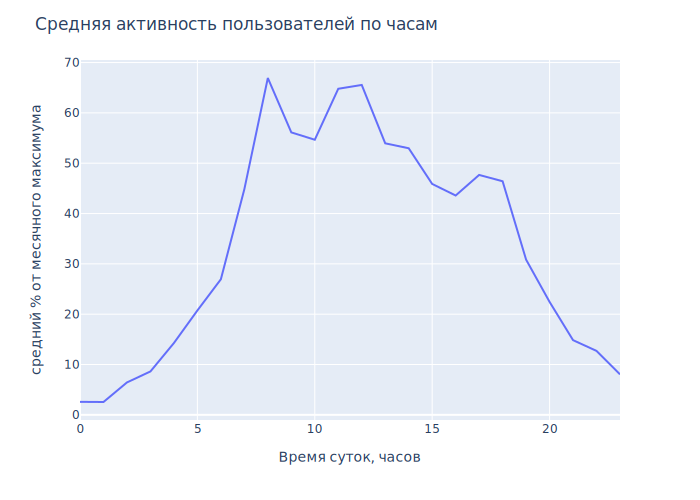

In [75]:
orders['weekday'] = orders['finished_at'].dt.dayofweek+1
orders_by_weekdays = orders[orders['status'] == 'finished'] \
                            .groupby(['month', 'weekday'], as_index = False) \
                            .agg({'id':'count'}) \
                            .pivot_table('id', index = 'weekday', columns = 'month')
orders_by_weekdays = orders_by_weekdays[[9, 10, 11, 12, 1, 2, 3, 4, 5, 6]]
activity_percent = (orders_by_weekdays.loc[:,]*100 / orders_by_weekdays.max(axis = 0)).round(1)
activity_percent['avg'] = activity_percent.mean(axis = 1)

activity_percent_style = activity_percent.style \
                                         .set_caption('Активность по дням недели и месяцам, количество заявок в % от максимума') \
                                         .background_gradient(subset = order_month_list.append('avg'), cmap='Blues') \
                                         .format(precision=1)

display(activity_percent_style)

orders['hour'] = orders['finished_at'].dt.hour
orders_by_dayhours = orders[orders['status'] == 'finished'] \
                            .groupby(['month', 'hour'], as_index = False) \
                            .agg({'id':'count'}) \
                            .pivot_table('id', index = 'hour', columns = 'month') \
                            .fillna(0)
orders_by_dayhours = orders_by_dayhours[[9, 10, 11, 12, 1, 2, 3, 4, 5, 6]]

hour_activity_percent = (orders_by_dayhours.loc[:,]*100 / orders_by_dayhours.max(axis = 0)).round(1)
hour_activity_percent['avg'] = hour_activity_percent.mean(axis = 1)

fig = px.line(hour_activity_percent['avg'])
fig.update_xaxes(title_text='Время суток, часов')
fig.update_yaxes(title_text='средний % от месячного максимума')
fig.update_layout(title_text = 'Средняя активность пользователей по часам', showlegend=False)
fig.show('svg')

**Вывод.**

Активность пользователей в целом соответствует рабочей активности при 5-дневном рабочем дне. 
Внутри дня можно выделить три группы времени по степени активности пользователей: 
- с 8.00 до 15.00 - максимальный уровень активности (соответствует зоне выше 50% на графике);
- с 15.00 до 19.00 - средний уровень (от 30 до 50%);
- с 20.00 до 8.00 - низкий уровень (меньше 20%). 
Практически полное отсутствие активности (или единичные случаи) наблюдается лишь с 00:00 до 02:00.

По дням недели активность также соответствует ритму 5-дневного рабочего дня. Минимальная активность характерна для выходных дней и пятницы (по сравнению с будними днями, хотя она всё равно довольно высока). 
При этом в воскресенье пользователи в среднем активнее, чем в пятницу и субботу. 
Максимальная активность наблюдается по вторникам. В понедельник, среду и четверг уровень активности примерно одинаков. 

# Анализ повторных заявок

Рассмотрим клиентов, имеющих повторные заявки и рассчитаем, какова конверсия в каждую следующую заявку, а также каков уровень повторных заявок в среднем по клиентам и каково распределение этого уровня. 

Число пользователей, совершающих повторные заявки и уровни конверсии в повторные заявки:


,orders_number,count_users,"CR_abs, %","CR_rel, %"
0,1,655,100.0,-
1,2,84,12.8,12.8
2,3,19,2.9,22.6
3,4,9,1.4,47.4
4,5,5,0.8,55.6


Средний уровень повторных заявок: 1.3


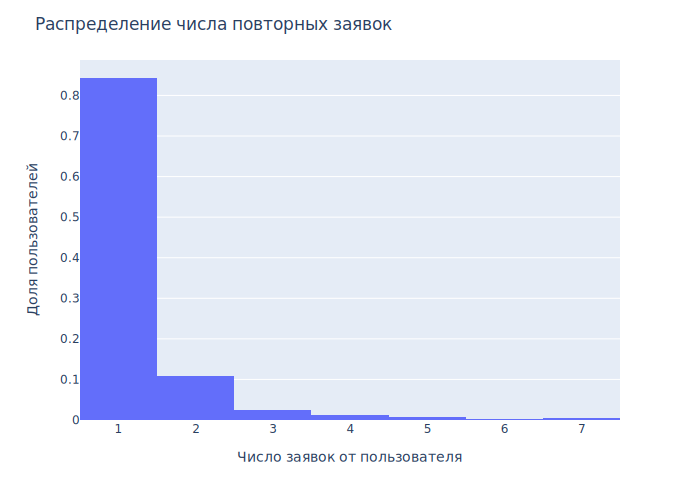

In [76]:
users_number_orders = orders[orders['status'] == 'finished'].groupby('user_id', as_index = False) \
                                                            .agg({'id':'count'}) \
                                                            .rename(columns = {'id':'orders_count'})

orders_numbers = users_number_orders.groupby('orders_count', as_index = False) \
                                     .agg({'user_id':'count'}) \
                                     .rename(columns = {'user_id':'count_users', 'orders_count':'orders_number'}) \
                                     .head(5)

orders_numbers['CR_abs, %'] = round((orders_numbers['count_users']*100/orders_numbers['count_users'].iloc[0]),1)
orders_numbers['CR_rel, %'] = round((orders_numbers['count_users']*100/orders_numbers['count_users'].shift(1)),1)
orders_numbers = orders_numbers.fillna("-")
avg_orders_by_user = users_number_orders['orders_count'].mean().round(1)

print('Число пользователей, совершающих повторные заявки и уровни конверсии в повторные заявки:')
display(orders_numbers)

print(f'Средний уровень повторных заявок: {avg_orders_by_user}')
fig = px.histogram(
    users_number_orders.query('orders_count < 10'), 
    x='orders_count',
    histnorm='probability')
fig.update_xaxes(title_text='Число заявок от пользователя')
fig.update_yaxes(title_text='Доля пользователей')
fig.update_layout(title_text = 'Распределение числа повторных заявок')
fig.show('svg')

**Вывод.**

Распределение числа заявок имеет вид классического распределения Пуассона. 
Абсолютная конверсия в повторную заявку (вторую) составляет всего 12,8%. Таким образом, клиентский отток после первой заявки является довольно большим. 

Больше 4х заявок совершила исчезающе малая доля пользователей. В среднем уровень повторных заявок составляет 1,3. Но при этом относительная конверсия в каждую следующую заявку увеличивается.

Для более детального анализа удержания клиентов необходимо рассмотреть его в контексте времени следующей заявки. 

 # Анализ удержания клиентов (Retention)
 
 

Период следующего заказа,9,10,11,12,1,2,3,4,5,6
Когорты по месяцам,,,,,,,,,,
9,3,2,2,0,1,0,0,1,0,0
10,24,15,15,7,2,1,3,1,1,
11,37,22,12,1,3,3,2,0,,
12,43,17,3,5,5,5,2,,,
1,30,4,5,5,7,1,,,,
2,8,2,2,1,0,,,,,
3,14,6,5,3,,,,,,
4,22,8,7,,,,,,,
5,19,8,,,,,,,,


Период следующего заказа,9,10,11,12,1,2,3,4,5,6
Когорты по месяцам,,,,,,,,,,
9,100.0,66.7,66.7,0.0,33.3,0.0,0.0,33.3,0.0,0.0
10,100.0,62.5,62.5,29.2,8.3,4.2,12.5,4.2,4.2,
11,100.0,59.5,32.4,2.7,8.1,8.1,5.4,0.0,,
12,100.0,39.5,7.0,11.6,11.6,11.6,4.7,,,
1,100.0,13.3,16.7,16.7,23.3,3.3,,,,
2,100.0,25.0,25.0,12.5,0.0,,,,,
3,100.0,42.9,35.7,21.4,,,,,,
4,100.0,36.4,31.8,,,,,,,
5,100.0,42.1,,,,,,,,


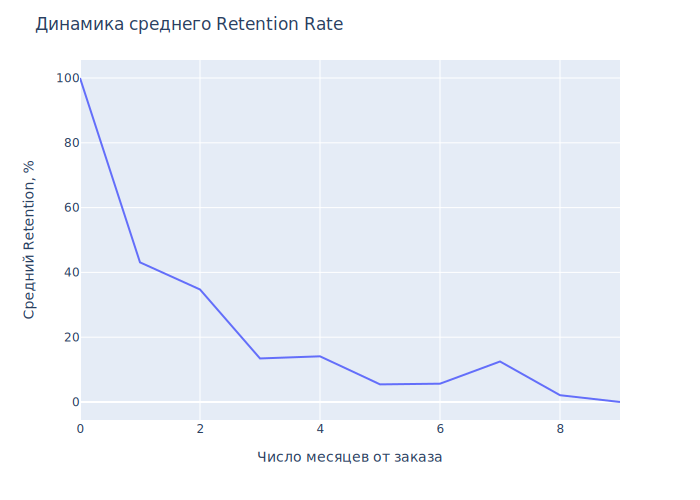

In [77]:
repeated_users = users_number_orders[users_number_orders['orders_count'] > 1].user_id
repeated_orders = orders[orders['status'] == 'finished'].query('user_id in @repeated_users')
orders_of_users = pd.DataFrame(repeated_orders.pivot_table('id', index = 'month', columns = 'user_id', aggfunc = 'count') \
                                               .count(), columns=['number_of_orders']) \
                                               .reset_index()
retention_users = orders_of_users[orders_of_users['number_of_orders'] > 1]['user_id']
retention_orders = repeated_orders[np.isin(repeated_orders['user_id'], retention_users)]

retention_users_month = retention_orders.pivot_table('id', index = 'user_id', columns = 'month', aggfunc = 'count')
retention_users_month = retention_users_month[[9, 10, 11, 12, 1, 2, 3, 4, 5, 6]].reset_index()
order_month_list = list(retention_users_month.columns)[1:]
retention_table = pd.DataFrame(columns = order_month_list, index = order_month_list)

for i in order_month_list:
    
    start_month_users = retention_users_month[['user_id',i]][retention_users_month[i].notna()]['user_id']
    retention_table.loc[i,i] = start_month_users.count()
    
    for j in range(len(order_month_list)):
        try:
            next_month = order_month_list[order_month_list.index(i)+j]
            end_month_users = retention_users_month[['user_id',next_month]][retention_users_month[next_month].notna()] \
                                    .query('user_id in @start_month_users')['user_id']
            retention_table.loc[i,next_month] = end_month_users.count()
        except (IndexError, ValueError):
            pass

counter = 0
for i in order_month_list:
    retention_table.loc[i] = retention_table.loc[i].shift(-counter)
    counter += 1
        
retention_table = retention_table.rename_axis(index='Когорты по месяцам', columns="Период следующего заказа")
retention_table_style = retention_table.style \
                                       .set_caption('Абсолютное число вернувшихся клиентов по когортам:') \
                                       .background_gradient(subset = order_month_list, cmap='Greens') \
                                       .highlight_null('white') \
                                       .format(na_rep="")

retention_relative = pd.DataFrame(columns = order_month_list, index = order_month_list)
for i in order_month_list:
    retention_relative.loc[:,i] = retention_table.loc[:,i]*100 / retention_table.loc[:,9]
retention_relative = retention_relative.astype('float').round(1)

retention_relative = retention_relative.rename_axis(index='Когорты по месяцам', columns="Период следующего заказа")
retention_relative_style = retention_relative.style \
                                             .set_caption('% вернувшихся клиентов от первоначального числа по когортам:') \
                                             .background_gradient(subset = order_month_list, cmap='Blues') \
                                             .highlight_null('white') \
                                             .format(precision=1, na_rep="")

display(retention_table_style)
display(retention_relative_style)

fig = px.line(retention_relative.mean(axis = 0).reset_index(drop=True))
fig.update_xaxes(title_text='Число месяцев от заказа')
fig.update_yaxes(title_text = 'Средний Retention, %')
fig.update_layout(title_text = 'Динамика среднего Retention Rate', showlegend=False)
fig.show('svg')

**Вывод.**

Из немногочисленного числа клиентов, которые возвращались с новыми заявками в следующие месяцы, наибольшая их доля возвращалась в следующем месяце, и далее эта доля последовательно снижалась. Таким образом, для клиентов характерно возвращаться спустя недолгий промежуток времени - не более 4х месяцев для большинства клиентов. 

Для подтверждения данного вывода рассмотрим распределение "времени жизни" клиента - т.е. разницы в месяцах между его первым и последним заказом. Это распределение должно коррелировать с построенной динамикой среднего Retention.

# Оценка времени жизни клиента

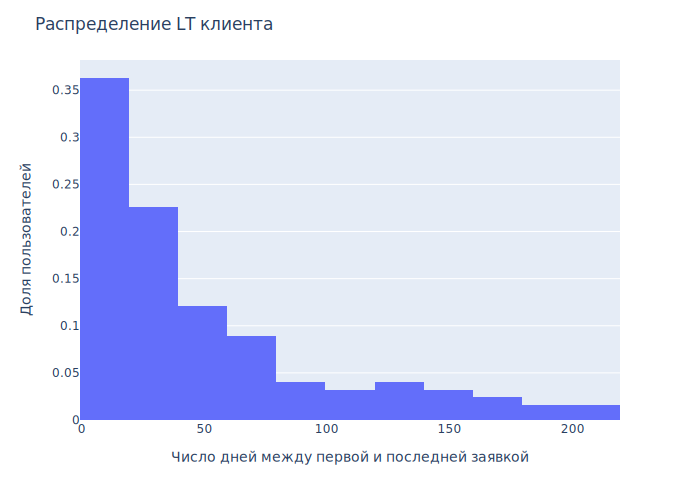

Описательная статистика по времени жизни клиента: 


,count,mean,std,min,25%,50%,75%,max
LT,124.0,48.63,51.85,0.0,10.0,30.0,64.25,219.0


In [78]:
first_last_orders = repeated_orders.groupby('user_id', as_index = False).agg({'finished_at':['min', 'max']})
first_last_orders['LT'] = first_last_orders['finished_at']['max'] - first_last_orders['finished_at']['min']
first_last_orders['LT'] = pd.to_numeric(first_last_orders['LT'].dt.round('D').dt.days, downcast='integer')

fig = px.histogram(first_last_orders['LT'], histnorm='probability')
fig.update_xaxes(title_text='Число дней между первой и последней заявкой')
fig.update_yaxes(title_text='Доля пользователей')
fig.update_layout(title_text = 'Распределение LT клиента', showlegend=False)
fig.show('svg')

LT_describe = pd.DataFrame(first_last_orders['LT'].describe()).round(2).transpose()
print('Описательная статистика по времени жизни клиента: ')
display(LT_describe)

**Вывод.**

Средний срок жизни клиента составляет 49 дней (7 недель). 
У половины клиентов из тех, кто совершил больше одного заказа - между их первым и последним заказом проходит не более 30 дней. Таких клиентов можно считать "разовыми", они обращаются с целью решения конкретной проблемы в конкретный момент и не нацелены на долгосрочное сотрудничество.

# Заключение

По результатам анализа можно заключить следующее: 
* деятельность имеет выраженную сезонность, которая составляет до 6 месяцев из 12 (ноябрь-январь и апрель-июнь). При этом рост спроса внутри этих периодов нелинейный - в новогодние и майские праздники активность снижается. В последние недели января и июня также наблюдается просадка уровня активности. 
* среднегодовой уровень DAU чуть больше 1 пользователя на один проект, в сезонный период максимальный среднемесячный уровень этого показателя доходит до 3. Максимальное значение MAU по всем проектам было достигнуто в декабре и составляло 185 (т.е. в среднем на проект около 62). Это означает, что в сезонный период активность увеличивается примерно в 2 раза;
* Внутри недели и внутри дня активность распределяется в соответствии с графиком 5-дневной рабочей недели при 12-часовом рабочем дне. Наиболее высокая активность наблюдается с понедельника по четверг, с 9:00 до 16:00. 
* уровень повторных заявок от пользователей в среднем за весь анализируемый период низкий - всего 1,3. Почти 85% пользователей делают лишь одну заявку и не обращаются в дальнейшем повторно. Для увеличения уровня повторных заявок можно рекомендовать введение или улучшение системы стимулирования совершения повторных заказов;
* Конверсия в каждую следующую заявку увеличивается, т.е. те пользователи, которые обратились повторно и затем имели успешный опыт, повторно обращаются чаще;
* Что касается времени повторного обращения, то почти половина из тех, кто совершает повторные заявки - совершают их в том же, либо следующем месяце. При прохождении более 5 месяцев от месяца обращения остаётся лишь 5-10% пользователей, которые повторно обращаются. Таким образом, основное взаимодействие с большинством клиентов сконцентрировано в коротком временном промежутке, не превышающем 3х месяцев; 
* Сделанный выше вывод подтверждает и оценка времени жизни клиента (заявителя), оценённый как разница между его первой и последней заявкой. В среднем это время составляет 49 дней (медиана - 30 дней). 

**Для увеличения коэффициента повторных заявок** предлагается рассмотреть следующие меры: 
* скидка на каждый следующий заказ (при неизвестных суммах заказов скидка может быть абсолютной либо относительной, в зависимости от суммы заказа);
* напоминание после выполнения заказа о специализации и услугах, которые могут быть оказаны;
* напоминание о важности заблаговременного обращения, поскольку сезонность ограничивает возможности оказания услуг для всех желающих (если бы такого ограничения не было, то уровень повторных заявок мог бы быть больше);
* развитие коммуникации в процессе работы над заказами, создание положительного впечатления, чтобы у клиента возникало желание вернуться. 